In [4]:
import database_utils
import model_utils
import data_utils
import matplotlib.pyplot as plt
import evaluate_final_model
import config


In [5]:
#--------------ANALISE RSULTADOS PSO-------------------
# Obter estatísticas dos experimentos
stats = database_utils.get_experiment_statistics()

print("📊 Estatísticas dos Experimentos PSO:")
print(f"  • Total de experimentos: {int(stats.get('total_experiments', 0))}")
print(f"  • Total de partículas avaliadas: {int(stats.get('total_particles', 0)):,}")
print(f"  • F1-Score médio: {stats.get('avg_f1_score', 0):.4f}")
print(f"  • Melhor F1-Score: {stats.get('best_f1_score', 0):.4f}")
print(f"  • Pior F1-Score: {stats.get('worst_f1_score', 0):.4f}")
print(f"  • Desvio padrão F1: {stats.get('std_f1_score', 0):.4f}")
print(f"  • Tempo médio por experimento: {stats.get('avg_total_time', 0):.1f}s")
print(f"  • Uso médio de CPU: {stats.get('avg_cpu_usage', 0):.1f}%")
print(f"  • Uso máximo de memória: {stats.get('avg_max_memory', 0):.1f} MB")

📊 Estatísticas dos Experimentos PSO:
  • Total de experimentos: 32
  • Total de partículas avaliadas: 12,800
  • F1-Score médio: 0.8442
  • Melhor F1-Score: 1.0000
  • Pior F1-Score: 0.0000
  • Desvio padrão F1: 0.1409
  • Tempo médio por experimento: 5182.1s
  • Uso médio de CPU: 12.5%
  • Uso máximo de memória: 11957.7 MB


In [6]:
# Obter melhor partícula
best_particle = database_utils.get_best_particle_overall()

if best_particle:
    print("🏆 Melhor Partícula Encontrada:")
    print(f"  • Experimento: {best_particle['experiment']}")
    print(f"  • Iteração: {best_particle['iteration']}")
    print(f"  • Partícula: {best_particle['particle']}")
    print(f"  • F1-Score: {best_particle['f1_score']:.4f}")
    print(f"  • Número de camadas: {best_particle['num_layers']}")
    
    # Decodificar parâmetros
    best_params = model_utils.decode_particle_position(best_particle['position'])
    print(f"  • Arquitetura: {best_params['neurons'][:best_params['n_layers']]}")
    print(f"  • Learning Rate: {best_params['learning_rate']:.6f}")
else:
    print("❌ Nenhum resultado encontrado no banco de dados.")

🏆 Melhor Partícula Encontrada:
  • Experimento: 5
  • Iteração: 12
  • Partícula: 17
  • F1-Score: 1.0000
  • Número de camadas: 4
  • Arquitetura: [128, 98, 128]
  • Learning Rate: 0.100000


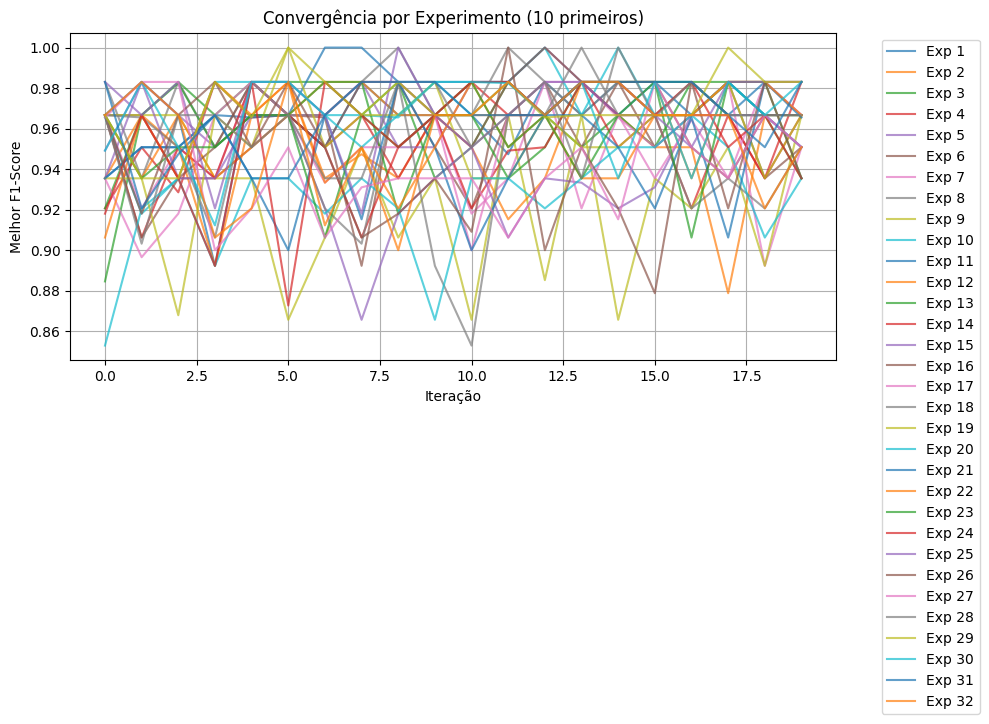

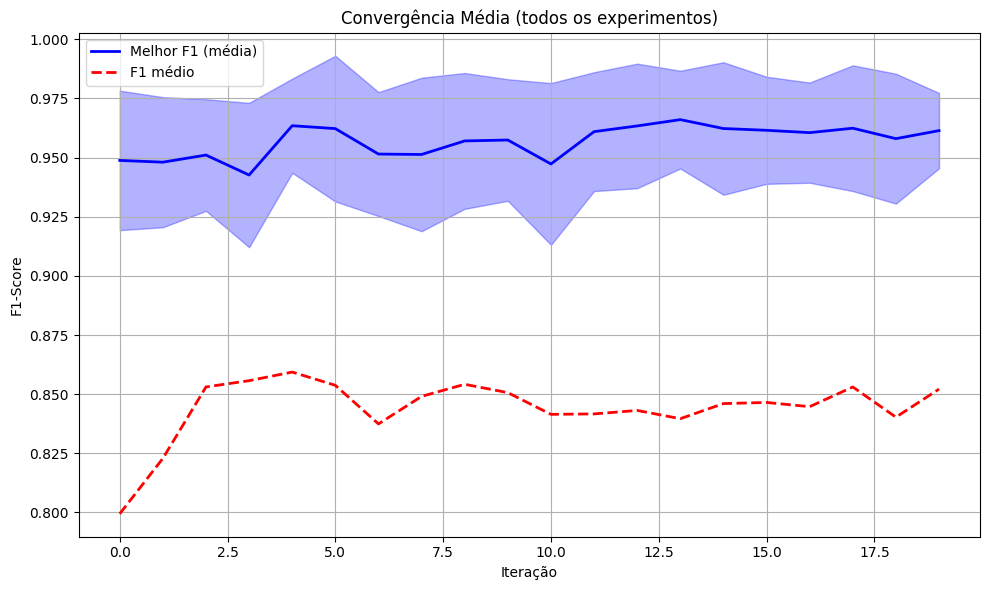

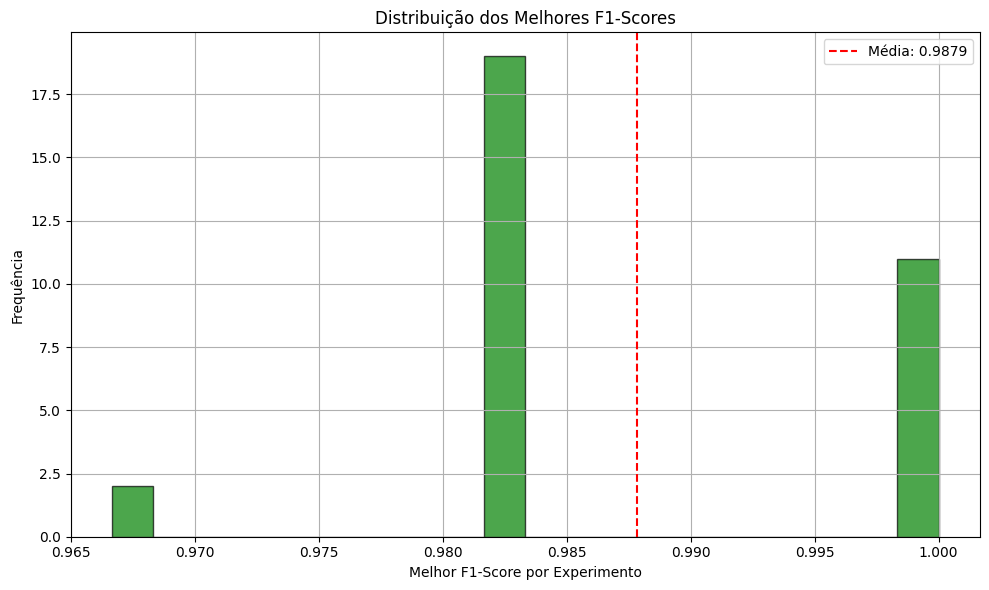

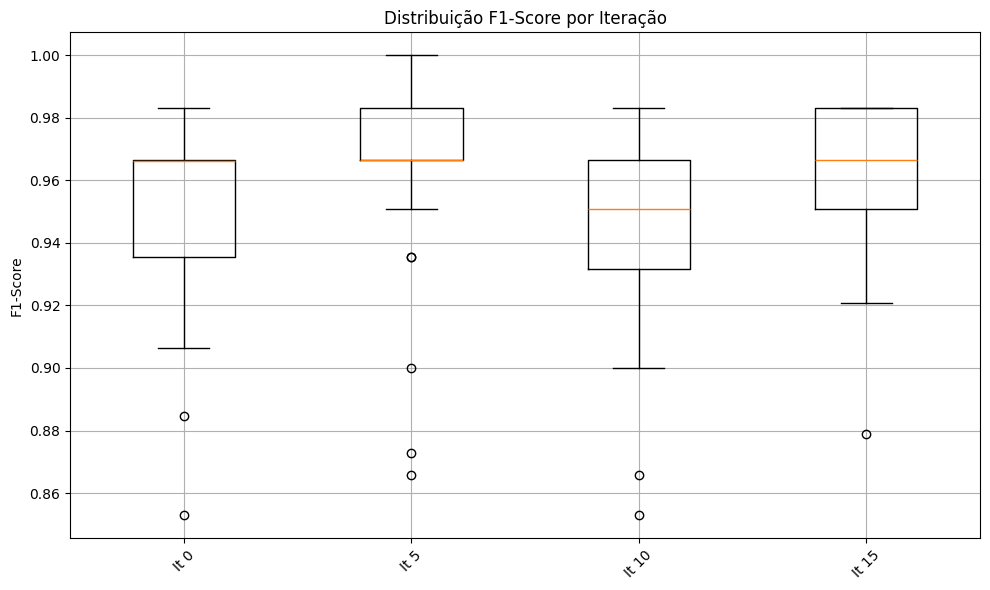

📈 Análise de convergência:
  • Melhor F1-Score final: 1.0000
  • F1-Score médio final: 0.9879
  • Desvio padrão: 0.0098
  • Melhoria média: 0.1884


In [8]:
convergence_data = database_utils.get_convergence_data()

if len(convergence_data) > 0:
    
    # Plot 1: Convergência por experimento
    plt.figure(figsize=(10, 6)) # Cada gráfico em sua própria figura
    for exp in convergence_data['num_experimento'].unique()[:32]:  # Mostrar apenas 10 experimentos
        exp_data = convergence_data[convergence_data['num_experimento'] == exp]
        plt.plot(exp_data['num_iteracao'], exp_data['best_f1_score'], alpha=0.7, label=f'Exp {exp}')
    plt.xlabel('Iteração')
    plt.ylabel('Melhor F1-Score')
    plt.title('Convergência por Experimento (10 primeiros)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout() # Ajusta o layout para evitar sobreposição
    plt.show() # Mostra o primeiro gráfico
    
    # Plot 2: Média de convergência
    plt.figure(figsize=(10, 6)) # Nova figura para o segundo gráfico
    avg_convergence = convergence_data.groupby('num_iteracao').agg({
        'best_f1_score': ['mean', 'std'],
        'avg_f1_score': 'mean'
    }).reset_index()
    
    iterations = avg_convergence['num_iteracao']
    best_mean = avg_convergence[('best_f1_score', 'mean')]
    best_std = avg_convergence[('best_f1_score', 'std')]
    avg_mean = avg_convergence[('avg_f1_score', 'mean')]
    
    plt.plot(iterations, best_mean, 'b-', label='Melhor F1 (média)', linewidth=2)
    plt.fill_between(iterations, best_mean - best_std, best_mean + best_std, alpha=0.3, color='blue')
    plt.plot(iterations, avg_mean, 'r--', label='F1 médio', linewidth=2)
    plt.xlabel('Iteração')
    plt.ylabel('F1-Score')
    plt.title('Convergência Média (todos os experimentos)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout() # Ajusta o layout
    plt.show() # Mostra o segundo gráfico
    
    # Plot 3: Distribuição dos melhores F1-scores
    plt.figure(figsize=(10, 6)) # Nova figura para o terceiro gráfico
    best_scores = convergence_data.groupby('num_experimento')['best_f1_score'].max()
    plt.hist(best_scores, bins=20, alpha=0.7, color='green', edgecolor='black')
    plt.axvline(best_scores.mean(), color='red', linestyle='--', label=f'Média: {best_scores.mean():.4f}')
    plt.xlabel('Melhor F1-Score por Experimento')
    plt.ylabel('Frequência')
    plt.title('Distribuição dos Melhores F1-Scores')
    plt.legend()
    plt.grid(True)
    plt.tight_layout() # Ajusta o layout
    plt.show() # Mostra o terceiro gráfico
    
    # Plot 4: Boxplot dos F1-scores por iteração
    plt.figure(figsize=(10, 6)) # Nova figura para o quarto gráfico
    iterations_sample = [0, 5, 10, 15, 20, 25, 29]  # Amostra de iterações
    data_for_box = []
    labels_for_box = []
    
    for it in iterations_sample:
        iter_data = convergence_data[convergence_data['num_iteracao'] == it]['best_f1_score']
        if len(iter_data) > 0:
            data_for_box.append(iter_data)
            labels_for_box.append(f'It {it}')
    
    if data_for_box:
        plt.boxplot(data_for_box, labels=labels_for_box)
        plt.ylabel('F1-Score')
        plt.title('Distribuição F1-Score por Iteração')
        plt.xticks(rotation=45)
        plt.grid(True)
    
    plt.tight_layout() # Ajusta o layout
    plt.show() # Mostra o quarto gráfico
    
    # Seções de impressão de texto permanecem inalteradas
    print(f"📈 Análise de convergência:")
    print(f"  • Melhor F1-Score final: {best_scores.max():.4f}")
    print(f"  • F1-Score médio final: {best_scores.mean():.4f}")
    print(f"  • Desvio padrão: {best_scores.std():.4f}")
    # Calcula a melhoria média usando o F1-score médio da iteração 0 (inicial)
    initial_avg_f1_score = avg_convergence[('avg_f1_score', 'mean')].iloc[0]
    print(f"  • Melhoria média: {(best_scores.mean() - initial_avg_f1_score):.4f}")
else:
    print("❌ Nenhum dado de convergência encontrado.")

🔍 Iniciando avaliação final do melhor modelo...
📊 Será executada validação cruzada estratificada com 5 folds.
🔍 Iniciando avaliação final do melhor modelo...
🏆 Melhor modelo encontrado:
  - Experimento: 5
  - Iteração: 12
  - F1-score: 1.0000
  - Arquitetura: [128, 98, 128]
  - Learning Rate: 0.100000

🔄 Executando validação cruzada estratificada (5 folds)...


Validação Cruzada:   0%|          | 0/5 [00:00<?, ?it/s]

Validação Cruzada: 100%|██████████| 5/5 [00:21<00:00,  4.23s/it, F1=0.8529, Acc=0.7436, AUC=0.5000]


📄 Relatório salvo em: relatorio_avaliacao_final.txt
📊 Matriz de confusão salva em: matriz_confusao.png


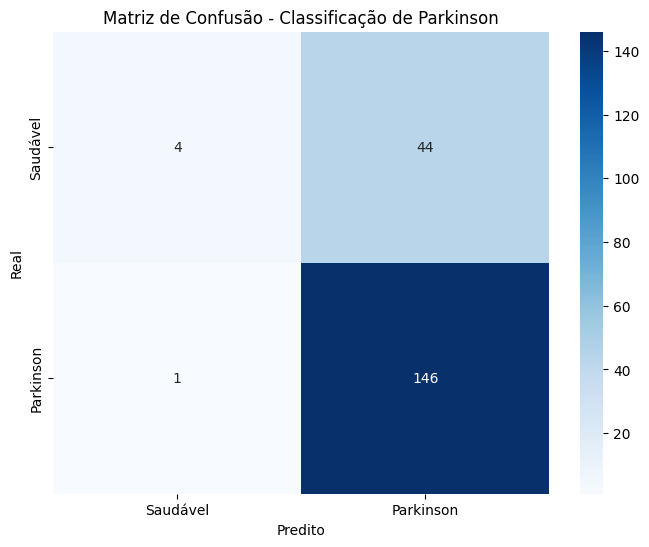


📋 RESUMO DA AVALIAÇÃO FINAL
F1-Score: 0.8669 ± 0.0207
Accuracy: 0.7692 ± 0.0397
AUC-ROC:  0.5941 ± 0.1287

✅ Avaliação final concluída!


In [9]:
# Executar avaliação final com validação cruzada
print("🔍 Iniciando avaliação final do melhor modelo...")
print("📊 Será executada validação cruzada estratificada com 5 folds.")

final_results = evaluate_final_model.evaluate_best_model()

print("\n✅ Avaliação final concluída!")

In [10]:
# Mostrar resultados detalhados
cv_metrics = final_results['cv_metrics']
global_metrics = final_results['global_metrics']

print("🎯 RESULTADOS FINAIS DA VALIDAÇÃO CRUZADA:")
print("=" * 50)
print(f"F1-Score:  {cv_metrics['f1_mean']:.4f} ± {cv_metrics['f1_std']:.4f}")
print(f"Accuracy:  {cv_metrics['accuracy_mean']:.4f} ± {cv_metrics['accuracy_std']:.4f}")
print(f"AUC-ROC:   {cv_metrics['auc_mean']:.4f} ± {cv_metrics['auc_std']:.4f}")
print("=" * 50)

print(f"\n🎯 MÉTRICAS GLOBAIS:")
print(f"F1-Score:  {global_metrics['f1_score']:.4f}")
print(f"Accuracy:  {global_metrics['accuracy']:.4f}")
print(f"AUC-ROC:   {global_metrics['auc']:.4f}")

# Matriz de confusão
cm = global_metrics['confusion_matrix']
tn, fp, fn, tp = cm.ravel()
print(f"\n🔢 MATRIZ DE CONFUSÃO:")
print(f"Verdadeiros Negativos: {tn}")
print(f"Falsos Positivos: {fp}")
print(f"Falsos Negativos: {fn}")
print(f"Verdadeiros Positivos: {tp}")

# Métricas adicionais
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

print(f"\n📈 MÉTRICAS DETALHADAS:")
print(f"Precisão: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Especificidade: {specificity:.4f}")

🎯 RESULTADOS FINAIS DA VALIDAÇÃO CRUZADA:
F1-Score:  0.8669 ± 0.0207
Accuracy:  0.7692 ± 0.0397
AUC-ROC:   0.5941 ± 0.1287

🎯 MÉTRICAS GLOBAIS:
F1-Score:  0.8665
Accuracy:  0.7692
AUC-ROC:   0.5628

🔢 MATRIZ DE CONFUSÃO:
Verdadeiros Negativos: 4
Falsos Positivos: 44
Falsos Negativos: 1
Verdadeiros Positivos: 146

📈 MÉTRICAS DETALHADAS:
Precisão: 0.7684
Recall: 0.9932
Especificidade: 0.0833


In [11]:
# Exportar todos os resultados
print("💾 Exportando resultados...")

# Exportar dados do PSO para CSV
database_utils.export_results_to_csv()

# Validar integridade do banco
validation = database_utils.validate_database()
print(f"\n✅ Validação do banco de dados:")
print(f"  • Tabelas encontradas: {validation['tables_found']}")
print(f"  • Registros pso_resultados: {validation['pso_resultados_count']:,}")
print(f"  • Registros pso_execucao: {validation['pso_execucao_count']}")
print(f"  • Experimentos únicos: {validation['unique_experiments']}")
print(f"  • Experimentos esperados: {validation['expected_experiments']}")

# Listar arquivos gerados
import os
files_generated = []
for file in os.listdir('.'):
    if file.endswith(('.csv', '.txt', '.png', '.db')):
        files_generated.append(file)

print(f"\n📁 Arquivos gerados:")
for file in sorted(files_generated):
    size = os.path.getsize(file) / 1024  # KB
    print(f"  • {file} ({size:.1f} KB)")

💾 Exportando resultados...
Resultados exportados para:
  - .\pso_resultados.csv
  - .\pso_execucao.csv

✅ Validação do banco de dados:
  • Tabelas encontradas: ['pso_resultados', 'pso_execucao']
  • Registros pso_resultados: 12,800
  • Registros pso_execucao: 32
  • Experimentos únicos: 32
  • Experimentos esperados: 32

📁 Arquivos gerados:
  • database copy.db (1968.0 KB)
  • database.db (1968.0 KB)
  • dataset.csv (496.8 KB)
  • matriz_confusao.png (78.2 KB)
  • populacao_inicial.csv (0.4 KB)
  • pso_execucao.csv (3.3 KB)
  • pso_parkinson.db (0.0 KB)
  • pso_resultados.csv (3345.8 KB)
  • relatorio_avaliacao_final.txt (1.8 KB)
  • requirements.txt (0.1 KB)


In [15]:
# Resumo final do projeto
print("🎉 PROJETO CONCLUÍDO COM SUCESSO!")
print("=" * 60)

print("📊 Carregando dataset de Parkinson...")
df = data_utils.load_parkinson_data()

# Informações do dataset
print(f"📊 Dataset: {len(df)} amostras, {len(df.columns)-1} features")
print(f"🎯 Problema: Classificação binária de Parkinson")

# Configuração PSO
print(f"\n⚙️ Configuração PSO:")
print(f"  • {config.PSO_CONFIG['experimentos']} experimentos independentes")
print(f"  • {config.PSO_CONFIG['n_particles']} partículas por experimento")
print(f"  • {config.PSO_CONFIG['iters']} iterações por experimento")
print(f"  • {config.PSO_CONFIG['experimentos'] * config.PSO_CONFIG['n_particles'] * config.PSO_CONFIG['iters']:,} avaliações totais")

# Melhor resultado
if 'final_results' in locals():
    cv_metrics = final_results['cv_metrics']
    print(f"\n🏆 Melhor Resultado (Validação Cruzada):")
    print(f"  • F1-Score: {cv_metrics['f1_mean']:.4f} ± {cv_metrics['f1_std']:.4f}")
    print(f"  • Accuracy: {cv_metrics['accuracy_mean']:.4f} ± {cv_metrics['accuracy_std']:.4f}")
    print(f"  • AUC-ROC: {cv_metrics['auc_mean']:.4f} ± {cv_metrics['auc_std']:.4f}")

# Arquitetura do melhor modelo
if 'best_particle' in locals() and best_particle:
    best_params = model_utils.decode_particle_position(best_particle['position'])
    print(f"\n🏗️ Melhor Arquitetura:")
    print(f"  • Camadas: {best_params['n_layers']}")
    print(f"  • Neurônios: {best_params['neurons'][:best_params['n_layers']]}")
    print(f"  • Learning Rate: {best_params['learning_rate']:.6f}")

# Arquivos gerados
print(f"\n📁 Arquivos principais gerados:")
print(f"  • pso_parkinson.db - Banco SQLite com todos os resultados")
print(f"  • pso_resultados.csv - Dados detalhados das partículas")
print(f"  • pso_execucao.csv - Resumo dos experimentos")
print(f"  • relatorio_avaliacao_final.txt - Relatório completo")
print(f"  • matriz_confusao.png - Visualização da matriz de confusão")

print("\n✅ Sistema PSO implementado e testado com sucesso!")
print("=" * 60)

🎉 PROJETO CONCLUÍDO COM SUCESSO!
📊 Carregando dataset de Parkinson...
📊 Dataset: 195 amostras, 22 features
🎯 Problema: Classificação binária de Parkinson

⚙️ Configuração PSO:
  • 32 experimentos independentes
  • 20 partículas por experimento
  • 20 iterações por experimento
  • 12,800 avaliações totais

🏆 Melhor Resultado (Validação Cruzada):
  • F1-Score: 0.8669 ± 0.0207
  • Accuracy: 0.7692 ± 0.0397
  • AUC-ROC: 0.5941 ± 0.1287

🏗️ Melhor Arquitetura:
  • Camadas: 4
  • Neurônios: [128, 98, 128]
  • Learning Rate: 0.100000

📁 Arquivos principais gerados:
  • pso_parkinson.db - Banco SQLite com todos os resultados
  • pso_resultados.csv - Dados detalhados das partículas
  • pso_execucao.csv - Resumo dos experimentos
  • relatorio_avaliacao_final.txt - Relatório completo
  • matriz_confusao.png - Visualização da matriz de confusão

✅ Sistema PSO implementado e testado com sucesso!
